## Intro:

Website for dataset: 
https://archive.ics.uci.edu/ml/datasets/bank+marketing

What we are predicting:
- Whether a certain client subscribes to a bank term deposit ("yes" or "no")

##### The Dataset:
- The original dataset consists of a total of 20 independent variables plus a y-variable (binary - "yes", "no")



## Importing necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
from copy import deepcopy
from collections import OrderedDict

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import scikitplot as skplt
%matplotlib inline

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
pd.set_option('precision',2)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

# Data Preprocessing:
#### Function for converting categorical variables into dummy variables

In [2]:
lst = ['marital', 'education', 'job', 'contact', 'poutcome']
def make_dummies(df, lst):
    temp = deepcopy(df)
    Y = df['y']
    temp = temp.drop(['y'], axis=1)
    for col in temp:
        if temp[col].dtype == 'object':
            tmp = pd.get_dummies(temp[col], prefix=col)
            num_col = len(tmp.columns)
            tmp = tmp.iloc[:,0:num_col-1]
            temp.drop([col], axis=1,inplace=True)
            lst = [temp, tmp]
            temp = pd.concat(lst, axis=1)
    return temp, Y

In [3]:
df_bankFull = pd.read_csv("bank-full.csv", delimiter=";")
df_bank = pd.read_csv("bank.csv", delimiter=";")

#### Standardizing Numerical Variables

- Standardizing the data is essential for clustering algorithms and dimension reduction.
- It's not necessary for tree based algorithms.

In [4]:
dfBankFull = deepcopy(df_bankFull)
cols_to_norm = ['age', 'balance', 'duration', 'day','campaign', 'pdays','previous']
dfBankFull[cols_to_norm] = dfBankFull[cols_to_norm]\
    .apply(lambda x: (x - x.min()) / (x.max()-x.min()))

#### Categorical Variables to Dummies

In [5]:
mainDF, y = make_dummies(dfBankFull, lst)

#### Downsampling Majority Class:

- In the cell directly below you can see the big imbalance between the two classes we're trying to predict. We're going to need to fix this so when it's fed into our models there is no prediction bias toward any one class.

In [6]:
y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [7]:
from sklearn.utils import resample

In [8]:
frames = [mainDF, y]
df = pd.concat(frames, axis=1)
df_maj = df[df.y=='no']
df_min = df[df.y=='yes']
df_majority_downsampled = resample(df_maj, replace=False,
                                  n_samples=5289,
                                  random_state=101)

frames_resampled = [df_majority_downsampled,df_min]
df_resampled = pd.concat(frames_resampled)

##### Results after downsampling the majority class:

In [9]:
df_resampled['y'].value_counts()

no     5289
yes    5289
Name: y, dtype: int64

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df_resampled.drop(['y'], axis=1),
                                                    df_resampled['y'], test_size=.3, random_state=101)

# Random Forests

#### How class_weights parameter was calculated: 
    - for 'no': sample_A / total_sample_size
            - 39922 / (39922+5289) = .88
         
    - for 'yes': sample_A / total_sample_size
            - 5289 / (39922+5289) = .12

#### Training & Predicting:

/home/mcliston/anaconda3/envs/machineL/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Predicted    no   yes
Actual               
no         1295   286
yes         166  1427
             precision    recall  f1-score   support

         no       0.89      0.82      0.85      1581
        yes       0.83      0.90      0.86      1593

avg / total       0.86      0.86      0.86      3174

Training set accuracy
1.0


Test set accuracy
0.8575929426591052
0.8575929426591052


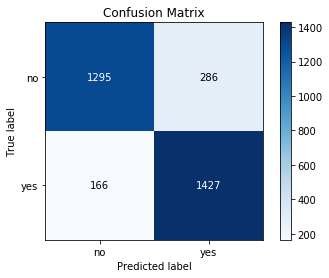

In [11]:
rf = RandomForestClassifier(n_estimators=647,
                            class_weight={'no':8.8, 'yes':1.2},
                            bootstrap=True,max_features=12,
                            oob_score=True,random_state=101).fit(x_train, y_train)


y_pred = rf.predict(x_test)
y_probas = rf.predict_proba(x_test)
skplt.metrics.plot_confusion_matrix(y_test,y_pred)
#print(confusion_matrix(y_test, prediction,labels=['no','yes']))
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))
print(classification_report(y_test, y_pred))
print('Training set accuracy')
print(rf.score(x_train,y_train))
print('\n')
print('Test set accuracy')
print(accuracy_score(y_test, y_pred))
print(rf.score(x_test, y_test))

###### Test set accuracy: 86%

# Plotting Receiver Operating Characteristic (ROC) Curve:
- In a ROC curve the true positive rate (sensitivity) is plotted against the false positive rate. 

- Each point on the ROC curve represents a sensitivty/specificity pair corresponding to a particular decision threshold.

- The area under the ROC curve (AUC) is a measure of how well a parameter can distinguish between two diagnostic groups.

/home/mcliston/anaconda3/envs/machineL/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


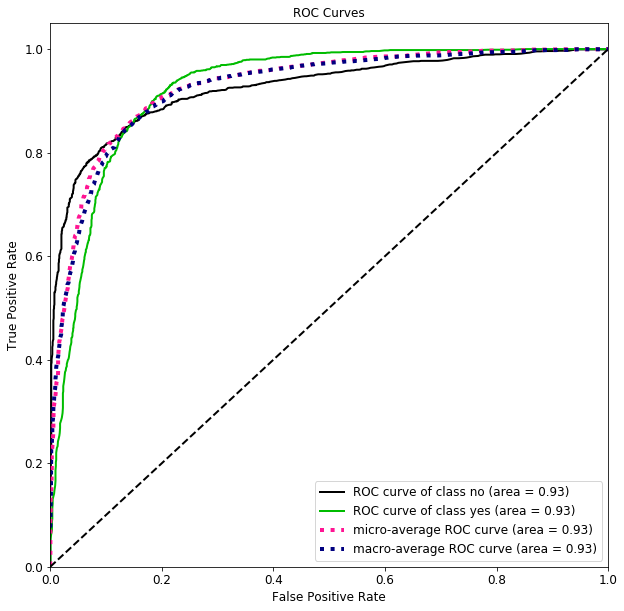

In [12]:
skplt.metrics.plot_roc_curve(y_test, y_probas,
                             figsize=(10,10),text_fontsize='large')

### Feature Importances:

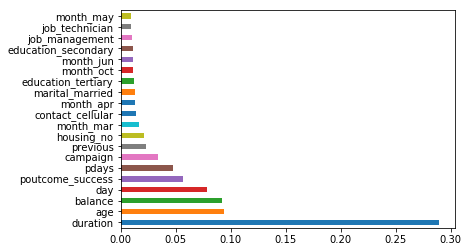

In [13]:
feat_imp = pd.Series(rf.feature_importances_, index=x_train.columns)
feat_imp = feat_imp.nlargest(20)
feat_imp.plot(kind='barh')

### Out-of_Bag error:

- method used to measure the prediction error of random forests.

- Visit link below for comprehensive explanation:

https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm


In [14]:
import warnings

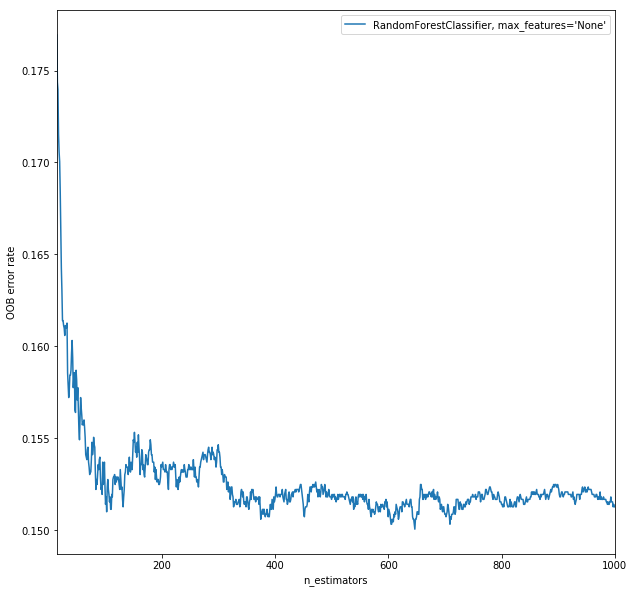

In [15]:
warnings.filterwarnings("ignore")

RANDOM_STATE = 101
ensemble_clfs = [
    ("RandomForestClassifier, max_features='None'",
     RandomForestClassifier(class_weight={'no':8.8, 'yes':1.2},
                            warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)


# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 1000
for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(x_train, y_train)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.figure(figsize=(10,10))
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")

In [16]:
lst = []
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    lst.append(xs)
    lst.append(ys)
error_df = pd.DataFrame(list(zip(lst[0],lst[1])))

#### Getting the n_estimators with lowest OOB score:

print('OOB Report:')
print("Number of estimators: {:<15} OOB error score: {:<15}"\
      .format(error_df.iloc[error_df[1].argmin(),:][0], np.round(error_df.iloc[error_df[1].argmin(),:][1],4)))

OOB Report:
Number of estimators: 647.0           OOB error score: 0.1501         


# Lime

In [20]:
import lime
import lime.lime_tabular

In [22]:
classes = y_test.unique()
testing = np.array(x_test)
training = np.array(x_train)

# fitting training data
explainer = lime.lime_tabular.LimeTabularExplainer(training, 
                                                   feature_names=x_train.columns, 
                                                   class_names=classes,
                                                   discretize_continuous=True)


In [24]:
x_train.shape

(7404, 42)

In [25]:
exp = explainer.explain_instance(testing[2], rf.predict_proba,
                                num_features=42,
                                top_labels=1)

exp.show_in_notebook(show_table=True, show_all=True)